# Sistema de Recomendação Open Finance: Personalização de Produtos Financeiros

# Definição - Sistema de recomendação

**Case Open Finance**

Com as primeiras etapas do Open Finance já concluídas pelas instituições financeiras, foi criada e populada uma base de dados de clientes e produtos de diferentes instituições que consentiram compartilhar seus dados via Open Finance com sua Fintech.
Com uma base de clientes e produtos financeiros é possível utilizar esses dados para oferecer produtos e serviços mais relevantes ao clientes.
Considerando o conjunto de dados de Open Finance fornecido, elabore um SR para sugerir aos clientes recomendações de serviços e/ou produtos relevantes com apoio de propriedades e técnicas estudadas na área de Recommendation Systems.
Materiais de apoio:

**Dataset reduzido compartilhado no material da aula 01 (handson)**

Banco central – Open Finance - área do desenvolvedor (https://openfinancebrasil.atlassian.net/wiki/spaces/OF/overview)

Banco central – Open Finance - diretório de urls com dados abertos e fechados das IFs (https://data.directory.openbankingbrasil.org.br/participants)

**Entregáveis**

Utilizar o Case Open Finance ou alguma outra necessidade de Recomendação dentro da QuantumFinance para aplicar os conceitos e técnicas de Sistemas de Recomendação.

**Escopo**

1. **Elaborar um slide com um contexto da Fintech e o objetivo para utilização de um SR.**
   
2. **Elaborar um desenho técnico da arquitetura da solução, incluindo as técnicas de recomendação escolhidas e devidamente justificadas ao contexto do projeto.**
   
3. **Criar e apresentar um protótipo operacional de como o SR é aplicado ao seu projeto integrado da Fintech. Inclua cenários de uso (fictícios) e/ou interfaces gráficas para materializar o que deseja demonstrar.**
   
4. **Implementar um código-fonte que aplique ao menos uma técnica de recomendação para sua Fintech. Essa parte deve ser construída em nível de prova de conceito, apenas para demonstrar que a utilização da técnica escolhida é factível ao Dataset disponibilizado e ao contexto do projeto integrado.**
  
5. **Essa prova de conceito será uma contribuição relevante dessa disciplina e servirá de acelerador na construção de um SR para utilização na sua Fintech.**

# Parte 1 - Problema negocio

# Problema de Negócio – Sistema de Recomendação em Open Finance

## Contexto

Com o avanço do **Open Finance**, instituições financeiras e Fintechs têm acesso a dados integrados de clientes e produtos de diferentes bancos, desde que os usuários consintam no compartilhamento. Esse cenário cria uma oportunidade estratégica: **utilizar inteligência artificial para recomendar produtos e serviços financeiros mais aderentes ao perfil de cada cliente**.

A Fintech **QuantumFinance** deseja explorar essa oportunidade criando um **Sistema de Recomendação (SR)** que seja capaz de sugerir produtos financeiros de forma personalizada, com base em dados de consumo, perfil sociodemográfico e padrões de clientes semelhantes.

## Objetivo de Negócio

O objetivo é **aumentar a taxa de cross-sell e up-sell de produtos financeiros**, elevando a **satisfação e retenção dos clientes**. Para isso, o modelo de recomendação deverá identificar **similaridades entre clientes e produtos**, prevendo quais ofertas são mais relevantes para cada perfil.

## Formulação do Problema

O desafio consiste em **construir um Sistema de Recomendação** capaz de responder à seguinte questão:

> “Dado o perfil e o histórico de consumo de um novo cliente, **quais produtos financeiros ele tem maior probabilidade de contratar** com base no comportamento de clientes semelhantes?”

Exemplo: se muitos clientes que contrataram a **Conta Corrente Plus** também adquiriram o **Seguro Residencial**, o modelo deve recomendar o Seguro Residencial a um novo cliente que acabou de contratar a Conta Corrente Plus.

A saída do sistema deverá ser entregue via **API**, contendo:

* Nome do cliente
* 
* Produto(s) recomendado(s)

## Dados Disponíveis

O dataset contém informações de clientes e consumo de produtos, com as seguintes variáveis:

* **Perfil do Cliente**:

  `id_cliente`,
  
  `nome`,
  
  `idade`,
  
  `sexo`,
  
  `cor`,
  
  `casado`,
  
  `qt_filhos`,
  
  `cidade`,
  
  `renda`,
  
  `qt_carros`,
  
  `qt_cart_cred`,
  
  `casa_propria`,
  
  `credit_score`,
  
  `endivid`,
  
  `trabalha`

* **Produtos Financeiros (variáveis binárias)**
  
  `Conta Corrente Plus`,

  `Cartão Platinum`,

  `Seguro Residencial`,

  `Crédito Pessoal Flex`,

  `Investimento Renda Fixa`

Essas variáveis binárias indicam **se o cliente já possui (1) ou não possui (0)** o respectivo produto.

## Técnicas de Modelagem Propostas

1. **KNN (K-Nearest Neighbors)**

   * Recomendação baseada em similaridade entre clientes.
   * Se clientes próximos no espaço de atributos consumiram um produto, ele será recomendado ao novo cliente.

2. **Clustering (ex: K-Means, DBSCAN)**

   * Agrupamento de clientes por similaridade de perfil.
   * Cada cluster tem um “pacote de produtos mais prováveis” que serve de base para recomendações.
     
## **Tipo Sistema recomendação aplicada**  
Nosso sistema de recomendação implementa a técnica de Filtragem Colaborativa baseada em Usuário (User-Based Collaborative Filtering) com KNN e métrica de similaridade do cosseno. O modelo identifica clientes semelhantes e recomenda produtos que são frequentes entre os vizinhos mais próximos, priorizando relevância e personalização.

In [48]:
#
!pip install kneed
!pip install mlxtend



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 35.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

# Parte 2 - Base dados

In [3]:
# ========= 1) Leitura robusta do CSV =========
PATH_CSV = r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Recommendations Systems\trabalho_final\input\data.csv"

def read_csv_br(path):
    encs = ['utf-8', 'utf-8-sig', 'latin1', 'cp1252']
    seps = [',', ';', '\t', '|']
    last_err = None
    for enc in encs:
        for sep in seps:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc, engine='python')
                # valida: precisa conter pelo menos as 5 colunas de produto
                if set([
                    'Conta Corrente Plus','Cartão Platinum','Seguro Residencial',
                    'Crédito Pessoal Flex','Investimento Renda Fixa'
                ]).issubset(df.columns):
                    return df
            except Exception as e:
                last_err = e
                continue
    raise RuntimeError(f"Falha ao ler CSV com encodings/separadores testados. Último erro: {last_err}")

df = read_csv_br(PATH_CSV)
df

,id_cliente,nome,idade,sexo,cor,casado,qt_filhos,cidade,renda,qt_carros,qt_cart_cred,casa_propria,credit_score,endivid,trabalha,Conta Corrente Plus,Cartão Platinum,Seguro Residencial,Crédito Pessoal Flex,Investimento Renda Fixa
0,1,JoÃ£o Rodrigues,33,M,Parda,Sim,0,BrasÃ­lia,65580,3,0,Sim,395,14328,Sim,1,1,1,0,0
1,2,Fernando Gomes,35,M,Branca,Sim,3,Salvador,165684,1,1,NÃ£o,404,12156,NÃ£o,1,0,0,0,0
2,3,Luiz Santos,53,M,Preta,NÃ£o,4,Porto Alegre,56466,0,5,Sim,596,2614,Sim,0,0,1,0,1
3,4,PatrÃ­cia Rodrigues,62,F,Branca,Sim,4,Porto Alegre,105669,3,3,NÃ£o,524,44866,NÃ£o,0,0,0,1,1
4,5,Ana Souza,76,F,IndÃ­gena,NÃ£o,1,Fortaleza,227425,3,1,NÃ£o,442,32325,NÃ£o,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,JoÃ£o Pereira,36,M,Preta,Sim,1,SÃ£o Paulo,283595,2,2,NÃ£o,428,128769,NÃ£o,1,1,0,1,1
9996,9997,Carlos Gomes,77,M,Amarela,Sim,0,Belo Horizonte,231373,2,4,NÃ£o,813,29940,Sim,1,0,0,1,0
9997,9998,Carolina Alves,26,F,Branca,NÃ£o,1,Recife,136998,1,4,Sim,445,28523,Sim,1,1,1,1,1
9998,9999,Fernanda Oliveira,64,F,Amarela,Sim,1,Porto Alegre,159894,1,0,Sim,382,73918,Sim,1,1,0,0,0


In [4]:
df.head()

,id_cliente,nome,idade,sexo,cor,casado,qt_filhos,cidade,renda,qt_carros,qt_cart_cred,casa_propria,credit_score,endivid,trabalha,Conta Corrente Plus,Cartão Platinum,Seguro Residencial,Crédito Pessoal Flex,Investimento Renda Fixa
0,1,JoÃ£o Rodrigues,33,M,Parda,Sim,0,BrasÃ­lia,65580,3,0,Sim,395,14328,Sim,1,1,1,0,0
1,2,Fernando Gomes,35,M,Branca,Sim,3,Salvador,165684,1,1,NÃ£o,404,12156,NÃ£o,1,0,0,0,0
2,3,Luiz Santos,53,M,Preta,NÃ£o,4,Porto Alegre,56466,0,5,Sim,596,2614,Sim,0,0,1,0,1
3,4,PatrÃ­cia Rodrigues,62,F,Branca,Sim,4,Porto Alegre,105669,3,3,NÃ£o,524,44866,NÃ£o,0,0,0,1,1
4,5,Ana Souza,76,F,IndÃ­gena,NÃ£o,1,Fortaleza,227425,3,1,NÃ£o,442,32325,NÃ£o,1,1,0,1,0


In [5]:
df.shape

(10000, 20)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id_cliente               10000 non-null  int64 
 1   nome                     10000 non-null  object
 2   idade                    10000 non-null  int64 
 3   sexo                     10000 non-null  object
 4   cor                      10000 non-null  object
 5   casado                   10000 non-null  object
 6   qt_filhos                10000 non-null  int64 
 7   cidade                   10000 non-null  object
 8   renda                    10000 non-null  int64 
 9   qt_carros                10000 non-null  int64 
 10  qt_cart_cred             10000 non-null  int64 
 11  casa_propria             10000 non-null  object
 12  credit_score             10000 non-null  int64 
 13  endivid                  10000 non-null  int64 
 14  trabalha                 10000 non-null

In [7]:
df.dtypes

id_cliente                  int64
nome                       object
idade                       int64
sexo                       object
cor                        object
casado                     object
qt_filhos                   int64
cidade                     object
renda                       int64
qt_carros                   int64
qt_cart_cred                int64
casa_propria               object
credit_score                int64
endivid                     int64
trabalha                   object
Conta Corrente Plus         int64
Cartão Platinum             int64
Seguro Residencial          int64
Crédito Pessoal Flex        int64
Investimento Renda Fixa     int64
dtype: object

In [8]:
df.columns

Index(['id_cliente', 'nome', 'idade', 'sexo', 'cor', 'casado', 'qt_filhos',
       'cidade', 'renda', 'qt_carros', 'qt_cart_cred', 'casa_propria',
       'credit_score', 'endivid', 'trabalha', 'Conta Corrente Plus',
       'Cartão Platinum', 'Seguro Residencial', 'Crédito Pessoal Flex',
       'Investimento Renda Fixa'],
      dtype='object')

# Parte 3 - Pré-processamento

In [9]:
# Correção de encoding em colunas categóricas
for col in ["sexo", "cor", "casado", "cidade", "casa_propria", "trabalha"]:
    df[col] = df[col].astype(str).str.encode("latin1").str.decode("utf-8", errors="ignore").str.strip()

# Normalizar categorias (exemplo: "Nao", "NÃO", "não" → "Não")
df = df.applymap(lambda x: x.strip().title() if isinstance(x, str) else x)
df

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\41561092.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip().title() if isinstance(x, str) else x)


,id_cliente,nome,idade,sexo,cor,casado,qt_filhos,cidade,renda,qt_carros,qt_cart_cred,casa_propria,credit_score,endivid,trabalha,Conta Corrente Plus,Cartão Platinum,Seguro Residencial,Crédito Pessoal Flex,Investimento Renda Fixa
0,1,Joã£O Rodrigues,33,M,Parda,Sim,0,Brasília,65580,3,0,Sim,395,14328,Sim,1,1,1,0,0
1,2,Fernando Gomes,35,M,Branca,Sim,3,Salvador,165684,1,1,Não,404,12156,Não,1,0,0,0,0
2,3,Luiz Santos,53,M,Preta,Não,4,Porto Alegre,56466,0,5,Sim,596,2614,Sim,0,0,1,0,1
3,4,Patrã­Cia Rodrigues,62,F,Branca,Sim,4,Porto Alegre,105669,3,3,Não,524,44866,Não,0,0,0,1,1
4,5,Ana Souza,76,F,Indígena,Não,1,Fortaleza,227425,3,1,Não,442,32325,Não,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,Joã£O Pereira,36,M,Preta,Sim,1,São Paulo,283595,2,2,Não,428,128769,Não,1,1,0,1,1
9996,9997,Carlos Gomes,77,M,Amarela,Sim,0,Belo Horizonte,231373,2,4,Não,813,29940,Sim,1,0,0,1,0
9997,9998,Carolina Alves,26,F,Branca,Não,1,Recife,136998,1,4,Sim,445,28523,Sim,1,1,1,1,1
9998,9999,Fernanda Oliveira,64,F,Amarela,Sim,1,Porto Alegre,159894,1,0,Sim,382,73918,Sim,1,1,0,0,0


In [10]:
df['cor'] = df['cor'].str.encode('latin1').str.decode('utf-8', errors='ignore')
df['cidade'] = df['cidade'].str.encode('latin1').str.decode('utf-8', errors='ignore')
df['casado'] = df['casado'].str.encode('latin1').str.decode('utf-8', errors='ignore')
df['cidade'] = df['cidade'].str.encode('latin1').str.decode('utf-8', errors='ignore')
df['nome'] = df['nome'].str.encode('latin1').str.decode('utf-8', errors='ignore')
df['casa_propria'] = df['casa_propria'].str.encode('latin1').str.decode('utf-8', errors='ignore')
df['trabalha'] = df['trabalha'].str.encode('latin1').str.decode('utf-8', errors='ignore')
df

,id_cliente,nome,idade,sexo,cor,casado,qt_filhos,cidade,renda,qt_carros,qt_cart_cred,casa_propria,credit_score,endivid,trabalha,Conta Corrente Plus,Cartão Platinum,Seguro Residencial,Crédito Pessoal Flex,Investimento Renda Fixa
0,1,JoO Rodrigues,33,M,Parda,Sim,0,Braslia,65580,3,0,Sim,395,14328,Sim,1,1,1,0,0
1,2,Fernando Gomes,35,M,Branca,Sim,3,Salvador,165684,1,1,No,404,12156,No,1,0,0,0,0
2,3,Luiz Santos,53,M,Preta,No,4,Porto Alegre,56466,0,5,Sim,596,2614,Sim,0,0,1,0,1
3,4,PatrCia Rodrigues,62,F,Branca,Sim,4,Porto Alegre,105669,3,3,No,524,44866,No,0,0,0,1,1
4,5,Ana Souza,76,F,Indgena,No,1,Fortaleza,227425,3,1,No,442,32325,No,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,JoO Pereira,36,M,Preta,Sim,1,So Paulo,283595,2,2,No,428,128769,No,1,1,0,1,1
9996,9997,Carlos Gomes,77,M,Amarela,Sim,0,Belo Horizonte,231373,2,4,No,813,29940,Sim,1,0,0,1,0
9997,9998,Carolina Alves,26,F,Branca,No,1,Recife,136998,1,4,Sim,445,28523,Sim,1,1,1,1,1
9998,9999,Fernanda Oliveira,64,F,Amarela,Sim,1,Porto Alegre,159894,1,0,Sim,382,73918,Sim,1,1,0,0,0


# Parte 4 - Análise exploratoria de dados

1. **Quais segmentos de clientes têm maior propensão a cada produto?**

   * Métrica: probabilidade $P(\text{produto}=1)$ por faixa de **idade**, **renda**, **credit\_score**, **endivid**, **trabalha**, **casa\_propria**, **qt\_cart\_cred**, **qt\_carros**, **casado**, **qt\_filhos**, **cidade**.
   * Decisão: priorizar ofertas por segmento com maior propensão.

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3472272682.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_idade = df.groupby('faixa_idade')['Conta Corrente Plus'].mean().reset_index()


Propensão Conta Corrente Plus por faixa de idade:
   faixa_idade  Conta Corrente Plus
0        <=25             0.791209
1       26-35             0.808317
2       36-45             0.802122
3       46-60             0.818803
4         >60             0.792912
Top cidades com maior propensão à Conta Corrente Plus:
   cidade  Conta Corrente Plus
4       4             0.815976
2       2             0.814516
5       5             0.812695
8       8             0.810345
7       7             0.805284


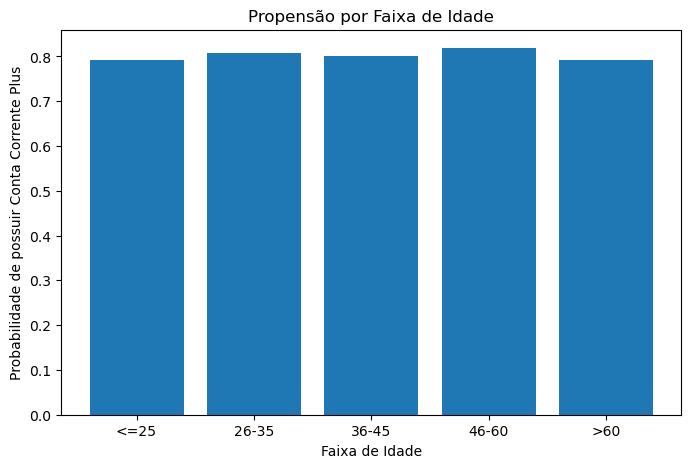

In [46]:
# Exemplo para idade, renda, credit_score, endivid
df['faixa_idade'] = pd.cut(df['idade'], bins=[0, 25, 35, 45, 60, 100], labels=['<=25','26-35','36-45','46-60','>60'])
df['faixa_renda'] = pd.qcut(df['renda'], q=4, labels=['Renda Baixa','Média-Baixa','Média-Alta','Renda Alta'])
df['faixa_credit'] = pd.qcut(df['credit_score'], q=4, labels=['Crédito Baixo','Médio-Baixo','Médio-Alto','Crédito Alto'])
df['faixa_endivid'] = pd.qcut(df['endivid'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])

# Exemplo: Conta Corrente Plus por faixa de idade
prop_idade = df.groupby('faixa_idade')['Conta Corrente Plus'].mean().reset_index()
print("Propensão Conta Corrente Plus por faixa de idade:\n", prop_idade)

# Exemplo completo e sem warnings:
prop_idade = df.groupby('faixa_idade', observed=False)['Conta Corrente Plus'].mean().reset_index()
prop_renda = df.groupby('faixa_renda', observed=False)['Conta Corrente Plus'].mean().reset_index()
prop_credit = df.groupby('faixa_credit', observed=False)['Conta Corrente Plus'].mean().reset_index()
prop_cidade = (
    df.groupby('cidade', observed=False)['Conta Corrente Plus']
      .mean()
      .reset_index()
      .sort_values('Conta Corrente Plus', ascending=False)
)
print("Top cidades com maior propensão à Conta Corrente Plus:")
print(prop_cidade.head())


plt.figure(figsize=(8,5))
plt.bar(prop_idade['faixa_idade'], prop_idade['Conta Corrente Plus'])
plt.xlabel('Faixa de Idade')
plt.ylabel('Probabilidade de possuir Conta Corrente Plus')
plt.title('Propensão por Faixa de Idade')
plt.show()

2. **Quais combinações de produtos aparecem com mais frequência (cestas) e geram maior lift de cross-sell?**

   * Métricas: **suporte, confiança e lift** entre: *Conta Corrente Plus*, *Cartão Platinum*, *Seguro Residencial*, *Crédito Pessoal Flex*, *Investimento Renda Fixa*.
   * Decisão: definir **bundles** e “próxima melhor oferta” (NBO).

In [49]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apenas colunas dos produtos
produtos = [
    "Conta Corrente Plus", "Cartão Platinum", "Seguro Residencial",
    "Crédito Pessoal Flex", "Investimento Renda Fixa"
]
df_prod = df[produtos].copy().astype(bool)

# Passo 1: Itens frequentes
frequentes = apriori(df_prod, min_support=0.01, use_colnames=True)

# Passo 2: Gere as regras
regras = association_rules(frequentes, metric="lift", min_threshold=1.0)

# Passo 3: Filtre para regras interessantes (confiança/lift alto)
regras = regras.sort_values("lift", ascending=False)

# Mostre as principais combinações (bundles)
print(regras[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


                                           antecedents  \
124  (Cartão Platinum, Crédito Pessoal Flex, Conta ...   
141      (Seguro Residencial, Investimento Renda Fixa)   
132  (Seguro Residencial, Investimento Renda Fixa, ...   
133            (Cartão Platinum, Crédito Pessoal Flex)   
109            (Cartão Platinum, Crédito Pessoal Flex)   
112      (Seguro Residencial, Investimento Renda Fixa)   
125  (Cartão Platinum, Crédito Pessoal Flex, Seguro...   
140     (Investimento Renda Fixa, Conta Corrente Plus)   
120  (Seguro Residencial, Cartão Platinum, Crédito ...   
145                          (Investimento Renda Fixa)   

                                           consequents  support  confidence  \
124      (Seguro Residencial, Investimento Renda Fixa)   0.0412    0.211608   
141  (Cartão Platinum, Crédito Pessoal Flex, Conta ...   0.0412    0.217414   
132            (Cartão Platinum, Crédito Pessoal Flex)   0.0412    0.268055   
133  (Seguro Residencial, Investimento Renda 

3. **Para clientes que possuem Conta Corrente Plus, qual a taxa histórica de adoção de Seguro Residencial e o lift vs. média?**

   * Métricas: **confiança** $P(\text{Seguro}=1 \mid \text{CC Plus}=1)$ e **lift** vs. $P(\text{Seguro}=1)$.
   * Decisão: validar a regra de recomendação “CC Plus ⇒ Seguro”.

In [51]:
# Probabilidade de ter Seguro Residencial entre quem tem Conta Corrente Plus
conf = (
    df[(df["Conta Corrente Plus"] == 1)]["Seguro Residencial"]
    .mean()
)
print(f"Confiança P(Seguro=1 | CC Plus=1): {conf:.3%}")

# Probabilidade média geral de Seguro Residencial
p_seguro = df["Seguro Residencial"].mean()
print(f"Probabilidade média P(Seguro=1): {p_seguro:.3%}")

# Lift: quanto mais provável o cliente adotar Seguro tendo CC Plus vs. base média
lift = conf / p_seguro if p_seguro > 0 else float('inf')
print(f"Lift: {lift:.2f}")

Confiança P(Seguro=1 | CC Plus=1): 39.509%
Probabilidade média P(Seguro=1): 39.260%
Lift: 1.01


4. **Como a propensão por produto varia por risco de crédito?**

   * Métricas: $P(\text{produto}=1)$ por faixas de **credit\_score** e **endivid** (e interação com **renda**).
   * Decisão: políticas de oferta responsáveis (limites, pré-requisitos, fluxo de aprovação).

In [69]:
# Quartis para credit_score, endivid, renda
df['faixa_credit'] = pd.qcut(df['credit_score'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
df['faixa_endivid'] = pd.qcut(df['endivid'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
df['faixa_renda'] = pd.qcut(df['renda'], q=4, labels=['Baixa','Média-Baixa','Média-Alta','Alta'])

produtos = [
    "Conta Corrente Plus", "Cartão Platinum", "Seguro Residencial",
    "Crédito Pessoal Flex", "Investimento Renda Fixa"
]

# Exemplo: propensão por faixa de credit_score
props_credit = df.groupby('faixa_credit', observed=False)[produtos].mean().reset_index()
props_credit

,faixa_credit,Conta Corrente Plus,Cartão Platinum,Seguro Residencial,Crédito Pessoal Flex,Investimento Renda Fixa
0,Baixo,0.796245,0.504195,0.388334,0.397123,0.495006
1,Médio-Baixo,0.802079,0.511395,0.403439,0.394242,0.481008
2,Médio-Alto,0.813796,0.498804,0.393142,0.560207,0.478469
3,Alto,0.798232,0.518087,0.385450,0.579582,0.489550


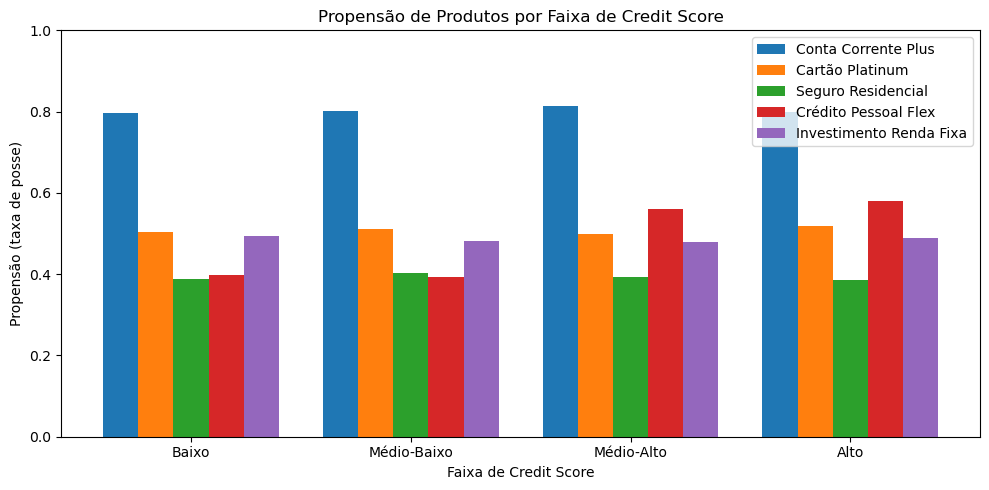

In [74]:
# Tabela já pronta: props_credit (linhas = faixas, colunas = produtos)
x = np.arange(len(props_credit['faixa_credit']))  # posição das barras
width = 0.16  # largura das barras

plt.figure(figsize=(10,5))
for i, prod in enumerate(produtos):
    plt.bar(x + i*width, props_credit[prod], width, label=prod)

plt.xticks(x + width*2, props_credit['faixa_credit'])
plt.xlabel("Faixa de Credit Score")
plt.ylabel("Propensão (taxa de posse)")
plt.title("Propensão de Produtos por Faixa de Credit Score")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [70]:
# Exemplo: propensão por faixa de endivid
props_endivid = df.groupby('faixa_endivid', observed=False)[produtos].mean().reset_index()
props_endivid

,faixa_endivid,Conta Corrente Plus,Cartão Platinum,Seguro Residencial,Crédito Pessoal Flex,Investimento Renda Fixa
0,Baixo,0.8024,0.4296,0.3940,0.4668,0.3932
1,Médio-Baixo,0.8048,0.4668,0.3880,0.4876,0.4392
2,Médio-Alto,0.7952,0.5308,0.3828,0.4868,0.5396
3,Alto,0.8080,0.6052,0.4056,0.4896,0.5720


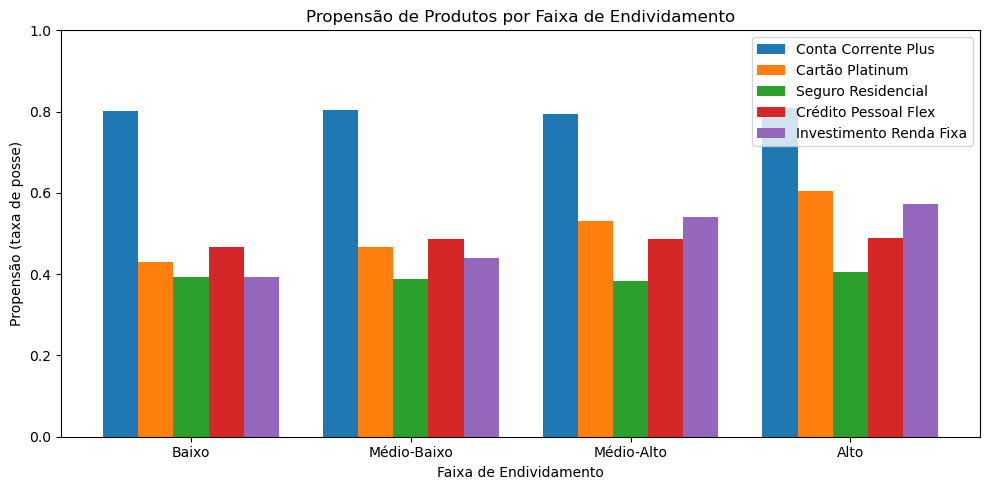

In [75]:
x = np.arange(len(props_endivid['faixa_endivid']))  # posição das barras
width = 0.16

plt.figure(figsize=(10,5))
for i, prod in enumerate(produtos):
    plt.bar(x + i*width, props_endivid[prod], width, label=prod)

plt.xticks(x + width*2, props_endivid['faixa_endivid'])
plt.xlabel("Faixa de Endividamento")
plt.ylabel("Propensão (taxa de posse)")
plt.title("Propensão de Produtos por Faixa de Endividamento")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

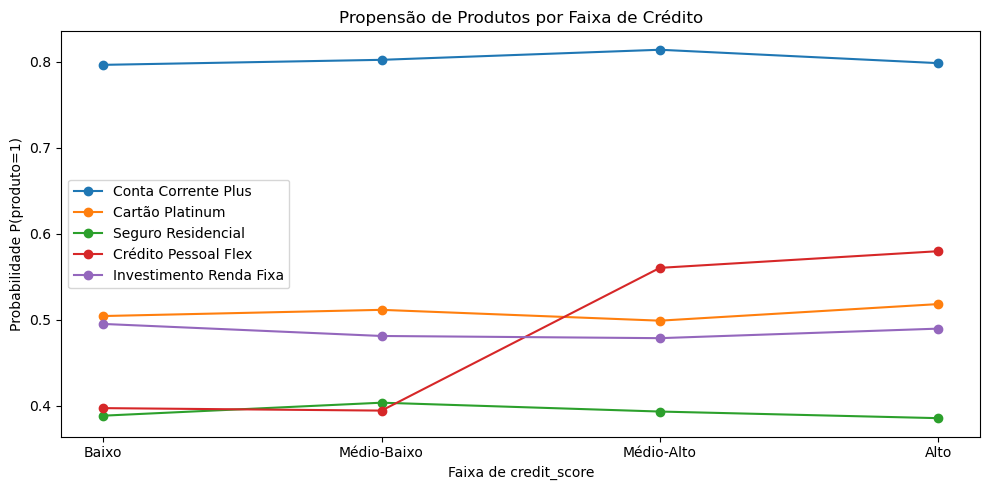

In [53]:
plt.figure(figsize=(10,5))
for prod in produtos:
    plt.plot(props_credit['faixa_credit'], props_credit[prod], marker='o', label=prod)
plt.title('Propensão de Produtos por Faixa de Crédito')
plt.xlabel('Faixa de credit_score')
plt.ylabel('Probabilidade P(produto=1)')
plt.legend()
plt.tight_layout()
plt.show()

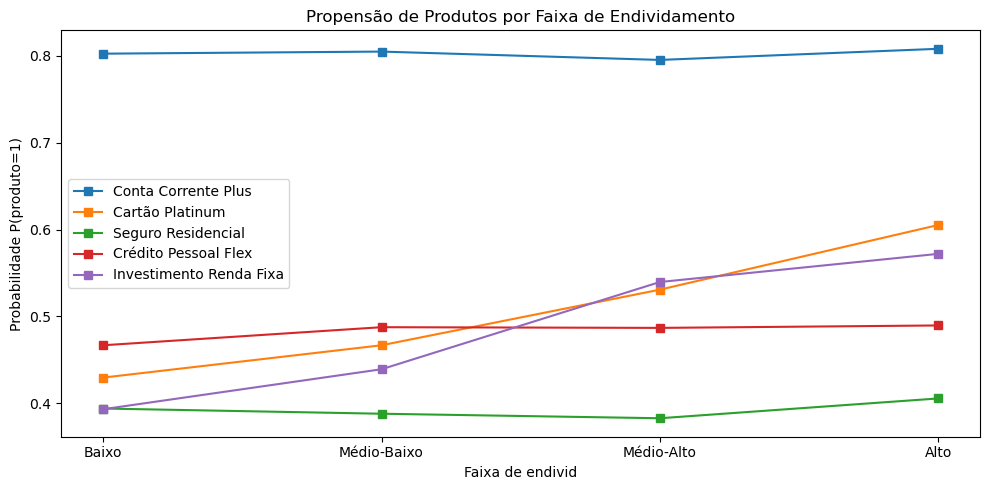

In [54]:
plt.figure(figsize=(10,5))
for prod in produtos:
    plt.plot(props_endivid['faixa_endivid'], props_endivid[prod], marker='s', label=prod)
plt.title('Propensão de Produtos por Faixa de Endividamento')
plt.xlabel('Faixa de endivid')
plt.ylabel('Probabilidade P(produto=1)')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3801697605.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(index='faixa_credit', columns='faixa_endivid', values=prod, aggfunc='mean')


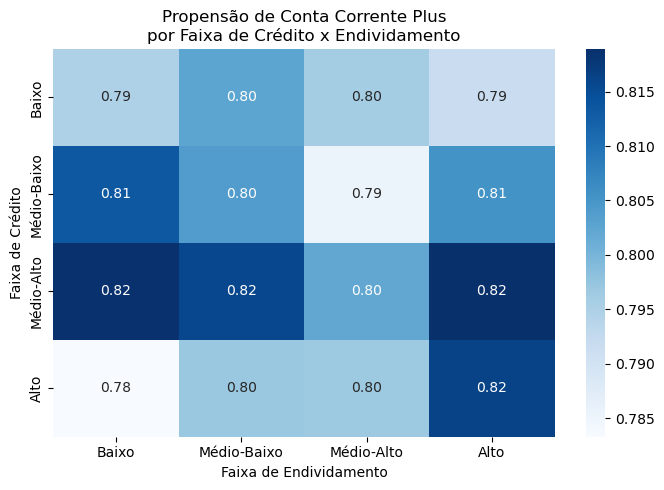

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3801697605.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(index='faixa_credit', columns='faixa_endivid', values=prod, aggfunc='mean')


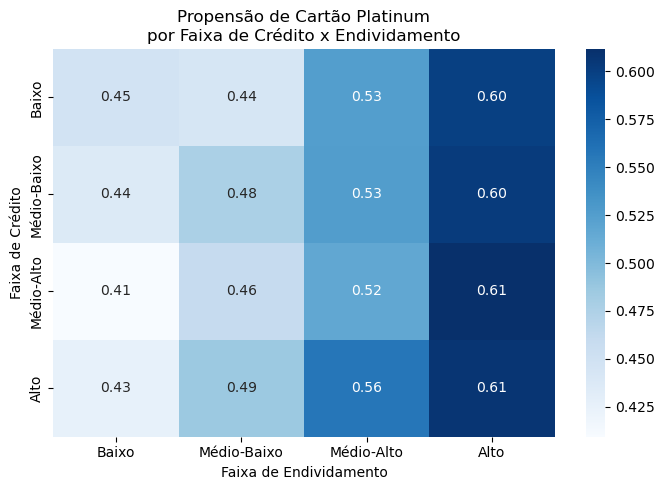

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3801697605.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(index='faixa_credit', columns='faixa_endivid', values=prod, aggfunc='mean')


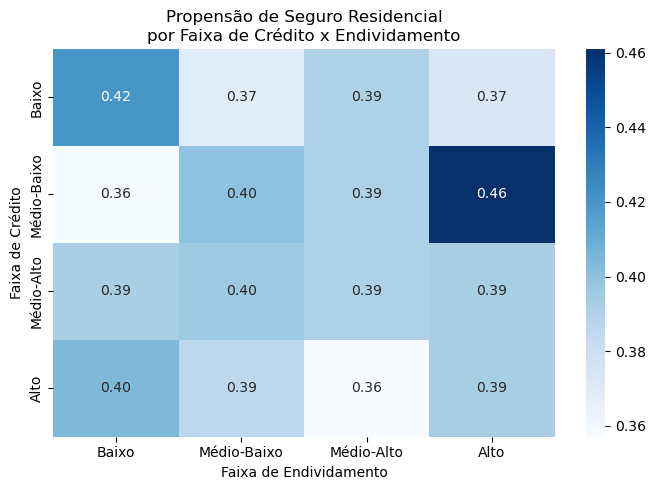

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3801697605.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(index='faixa_credit', columns='faixa_endivid', values=prod, aggfunc='mean')


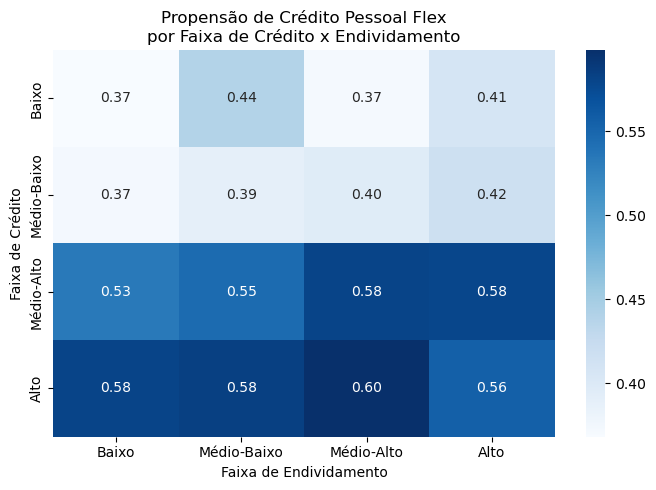

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3801697605.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(index='faixa_credit', columns='faixa_endivid', values=prod, aggfunc='mean')


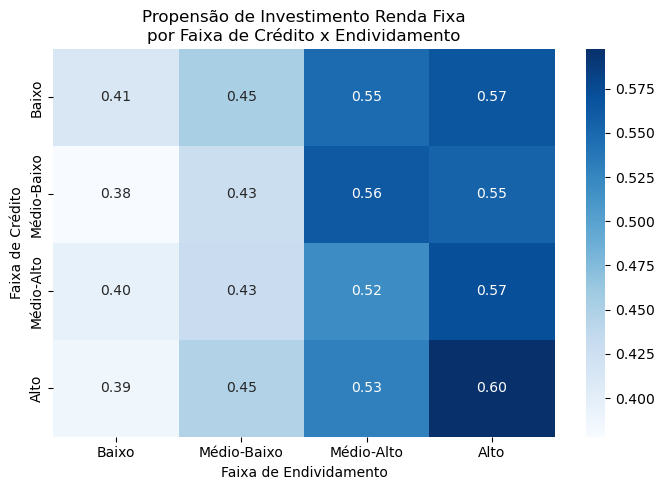

In [55]:
for prod in produtos:
    tabela = df.pivot_table(index='faixa_credit', columns='faixa_endivid', values=prod, aggfunc='mean')
    plt.figure(figsize=(7,5))
    sns.heatmap(tabela, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f'Propensão de {prod}\npor Faixa de Crédito x Endividamento')
    plt.xlabel('Faixa de Endividamento')
    plt.ylabel('Faixa de Crédito')
    plt.tight_layout()
    plt.show()

5. **Qual é a penetração atual de cada produto por faixa de renda e cidade?**

   * Métricas: **taxa de penetração** por **renda** (bins) × **cidade**.
   * Decisão: foco geográfico e adequação de ticket/oferta ao poder aquisitivo local.

In [56]:
df['faixa_renda'] = pd.qcut(df['renda'], q=4, labels=['Baixa', 'Média-Baixa', 'Média-Alta', 'Alta'])

produtos = [
    "Conta Corrente Plus", "Cartão Platinum", "Seguro Residencial",
    "Crédito Pessoal Flex", "Investimento Renda Fixa"
]

# Exemplo para um produto:
penetracao_cc = df.pivot_table(
    index='faixa_renda',
    columns='cidade',
    values='Conta Corrente Plus',
    aggfunc='mean'
)

print("Taxa de penetração Conta Corrente Plus por faixa de renda e cidade:")
print(penetracao_cc)


Taxa de penetração Conta Corrente Plus por faixa de renda e cidade:
cidade              0         1         2         3         4         5  \
faixa_renda                                                               
Baixa        0.822394  0.802326  0.805668  0.799213  0.809160  0.825203   
Média-Baixa  0.811245  0.807229  0.825726  0.801688  0.804082  0.799213   
Média-Alta   0.798419  0.752988  0.814229  0.811024  0.844828  0.774336   
Alta         0.758065  0.789256  0.812749  0.764925  0.808000  0.851064   

cidade              6         7         8         9  
faixa_renda                                          
Baixa        0.746032  0.805785  0.839357  0.779221  
Média-Baixa  0.815884  0.794521  0.780612  0.815385  
Média-Alta   0.820144  0.816667  0.830645  0.758491  
Alta         0.819549  0.806452  0.782979  0.797665  


C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\1570237782.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  penetracao_cc = df.pivot_table(


C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3791263597.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(


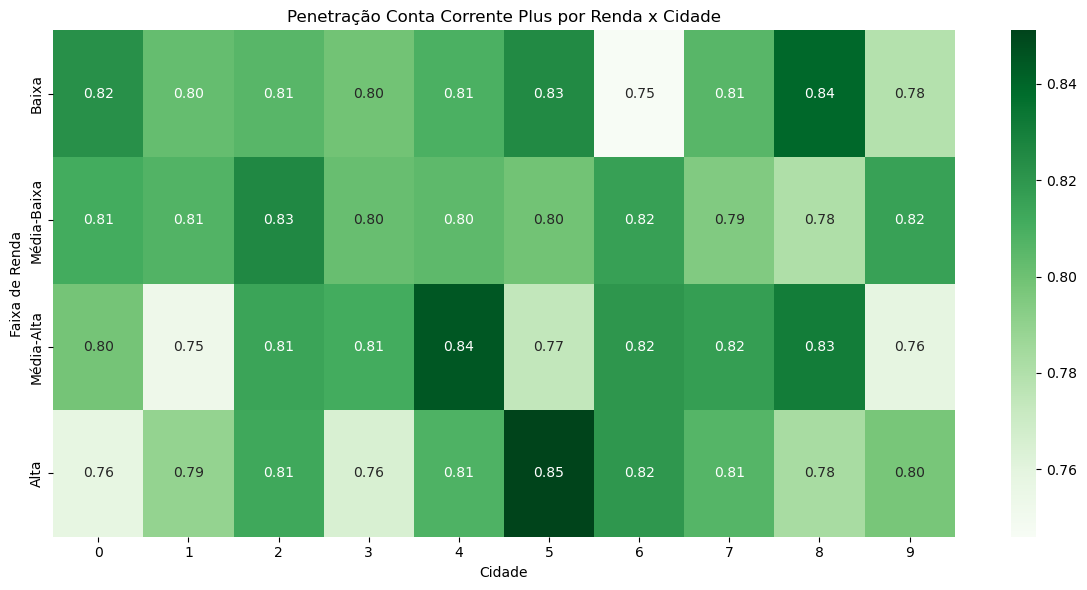

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3791263597.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(


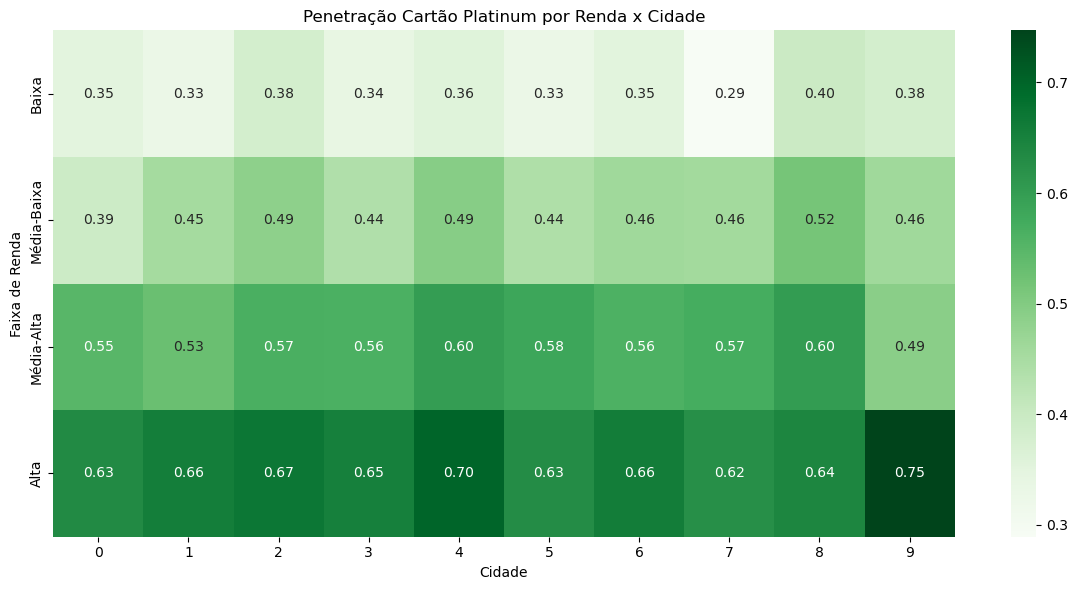

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3791263597.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(


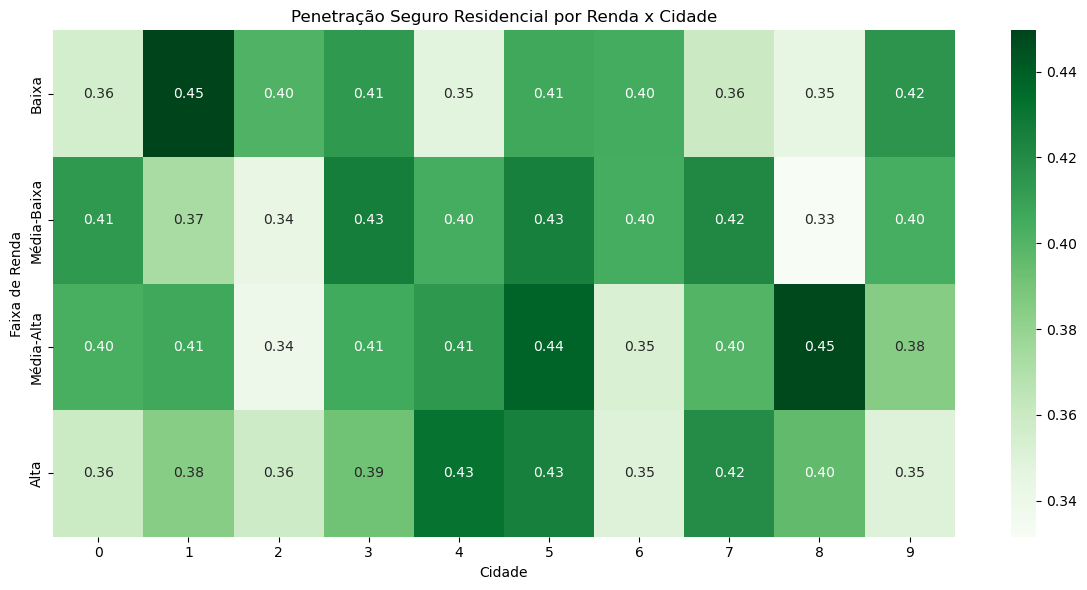

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3791263597.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(


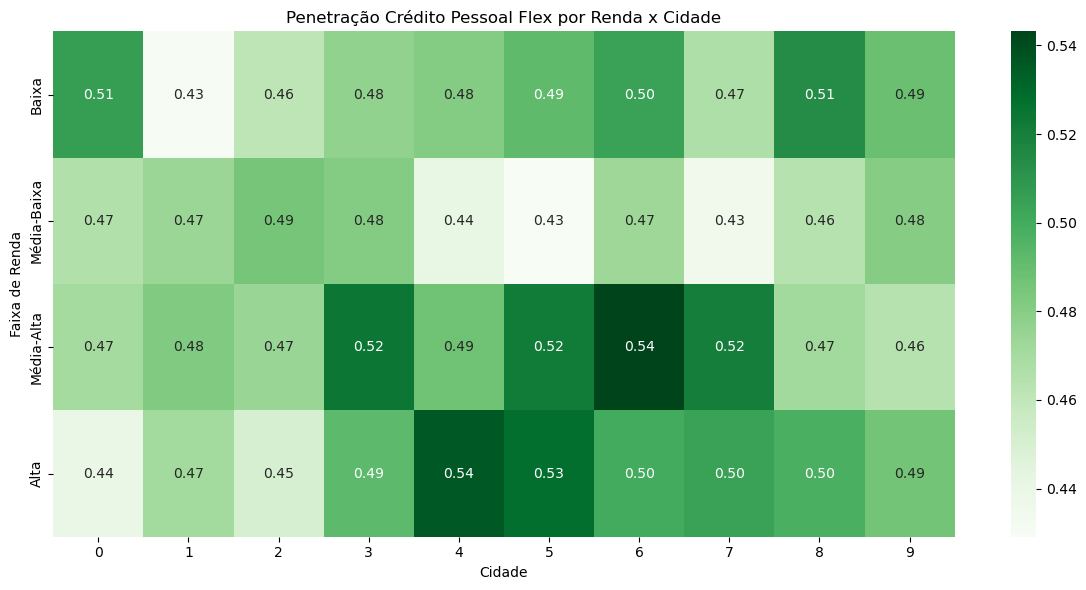

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\3791263597.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df.pivot_table(


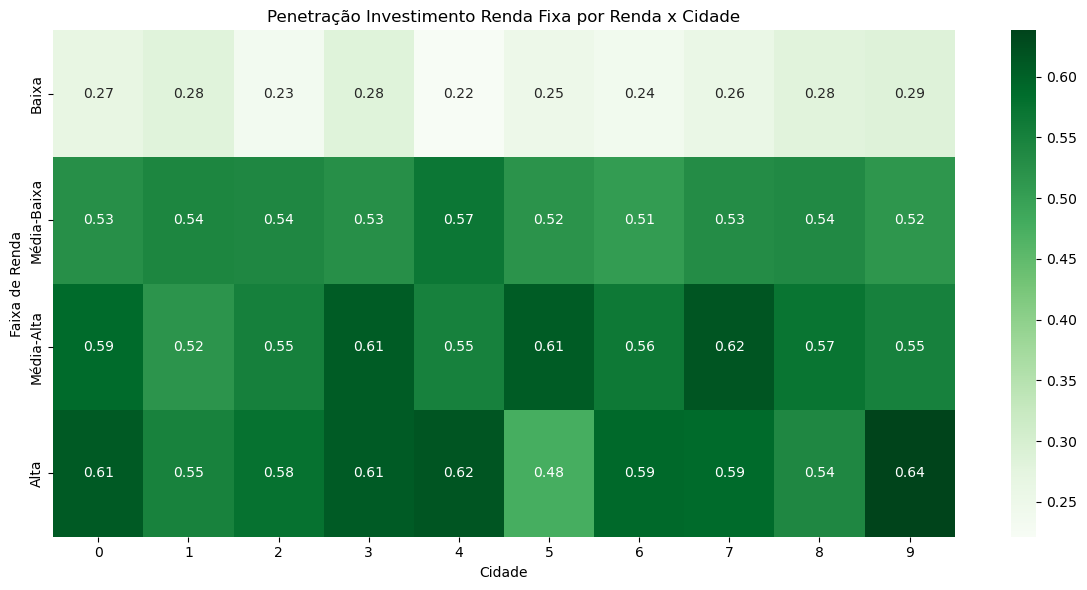

In [57]:
for prod in produtos:
    tabela = df.pivot_table(
        index='faixa_renda',
        columns='cidade',
        values=prod,
        aggfunc='mean'
    )
    plt.figure(figsize=(12,6))
    sns.heatmap(tabela, annot=True, fmt=".2f", cmap="Greens")
    plt.title(f"Penetração {prod} por Renda x Cidade")
    plt.xlabel("Cidade")
    plt.ylabel("Faixa de Renda")
    plt.tight_layout()
    plt.show()


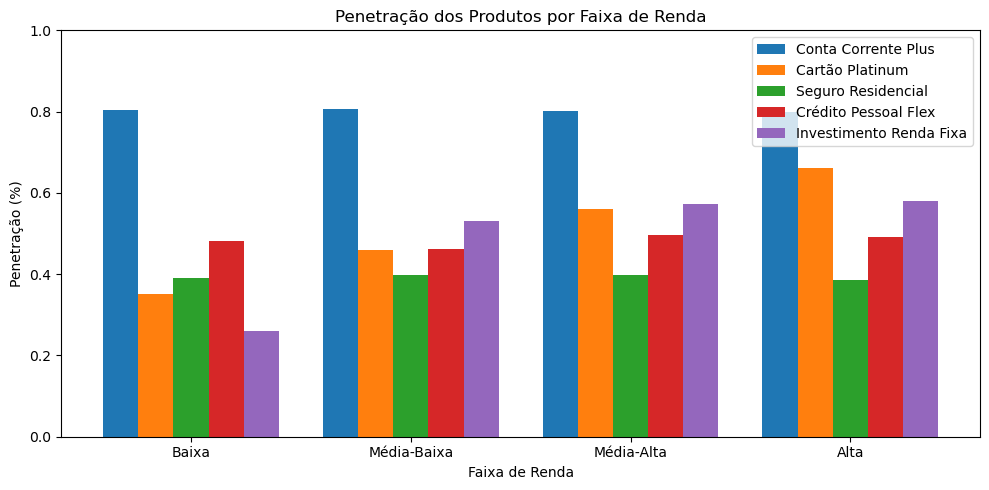

In [59]:
# Monte uma tabela de penetração: linhas=faixas de renda, colunas=produtos
penet_table = df.groupby('faixa_renda', observed=False)[produtos].mean().reset_index()

x = np.arange(len(penet_table['faixa_renda']))  # posições das barras
width = 0.16  # largura das barras

plt.figure(figsize=(10,5))
for i, prod in enumerate(produtos):
    plt.bar(x + i*width, penet_table[prod], width, label=prod)
plt.xticks(x + width*2, penet_table['faixa_renda'])
plt.xlabel("Faixa de Renda")
plt.ylabel("Penetração (%)")
plt.title("Penetração dos Produtos por Faixa de Renda")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Parte 5 - Limpeza dados

In [12]:
print(df.isnull().sum())

id_cliente                 0
nome                       0
idade                      0
sexo                       0
cor                        0
casado                     0
qt_filhos                  0
cidade                     0
renda                      0
qt_carros                  0
qt_cart_cred               0
casa_propria               0
credit_score               0
endivid                    0
trabalha                   0
Conta Corrente Plus        0
Cartão Platinum            0
Seguro Residencial         0
Crédito Pessoal Flex       0
Investimento Renda Fixa    0
dtype: int64


In [13]:
nulos = df.isnull().sum()
print(nulos[nulos > 0])

Series([], dtype: int64)


In [14]:
print("Total de valores nulos:", df.isnull().sum().sum())


Total de valores nulos: 0


In [15]:
df = df.drop(columns=['nome'])
df

,id_cliente,idade,sexo,cor,casado,qt_filhos,cidade,renda,qt_carros,qt_cart_cred,casa_propria,credit_score,endivid,trabalha,Conta Corrente Plus,Cartão Platinum,Seguro Residencial,Crédito Pessoal Flex,Investimento Renda Fixa
0,1,33,M,Parda,Sim,0,Braslia,65580,3,0,Sim,395,14328,Sim,1,1,1,0,0
1,2,35,M,Branca,Sim,3,Salvador,165684,1,1,No,404,12156,No,1,0,0,0,0
2,3,53,M,Preta,No,4,Porto Alegre,56466,0,5,Sim,596,2614,Sim,0,0,1,0,1
3,4,62,F,Branca,Sim,4,Porto Alegre,105669,3,3,No,524,44866,No,0,0,0,1,1
4,5,76,F,Indgena,No,1,Fortaleza,227425,3,1,No,442,32325,No,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,36,M,Preta,Sim,1,So Paulo,283595,2,2,No,428,128769,No,1,1,0,1,1
9996,9997,77,M,Amarela,Sim,0,Belo Horizonte,231373,2,4,No,813,29940,Sim,1,0,0,1,0
9997,9998,26,F,Branca,No,1,Recife,136998,1,4,Sim,445,28523,Sim,1,1,1,1,1
9998,9999,64,F,Amarela,Sim,1,Porto Alegre,159894,1,0,Sim,382,73918,Sim,1,1,0,0,0


# Parte 6 - Feature engineering

In [16]:
from sklearn.preprocessing import LabelEncoder

# Supondo que o df já está limpo
cat_cols = ['sexo', 'cor', 'cidade', 'casado', 'casa_propria', 'trabalha']

le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

    print(f"Mapping {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Mapping sexo: {'F': 0, 'M': 1}
Mapping cor: {'Amarela': 0, 'Branca': 1, 'Indgena': 2, 'Parda': 3, 'Preta': 4}
Mapping cidade: {'Belo Horizonte': 0, 'Braslia': 1, 'Curitiba': 2, 'Fortaleza': 3, 'Goinia': 4, 'Porto Alegre': 5, 'Recife': 6, 'Rio De Janeiro': 7, 'Salvador': 8, 'So Paulo': 9}
Mapping casado: {'No': 0, 'Sim': 1}
Mapping casa_propria: {'No': 0, 'Sim': 1}
Mapping trabalha: {'No': 0, 'Sim': 1}


In [17]:
# Visualizando dataset
df

,id_cliente,idade,sexo,cor,casado,qt_filhos,cidade,renda,qt_carros,qt_cart_cred,casa_propria,credit_score,endivid,trabalha,Conta Corrente Plus,Cartão Platinum,Seguro Residencial,Crédito Pessoal Flex,Investimento Renda Fixa
0,1,33,1,3,1,0,1,65580,3,0,1,395,14328,1,1,1,1,0,0
1,2,35,1,1,1,3,8,165684,1,1,0,404,12156,0,1,0,0,0,0
2,3,53,1,4,0,4,5,56466,0,5,1,596,2614,1,0,0,1,0,1
3,4,62,0,1,1,4,5,105669,3,3,0,524,44866,0,0,0,0,1,1
4,5,76,0,2,0,1,3,227425,3,1,0,442,32325,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,36,1,4,1,1,9,283595,2,2,0,428,128769,0,1,1,0,1,1
9996,9997,77,1,0,1,0,0,231373,2,4,0,813,29940,1,1,0,0,1,0
9997,9998,26,0,1,0,1,6,136998,1,4,1,445,28523,1,1,1,1,1,1
9998,9999,64,0,0,1,1,5,159894,1,0,1,382,73918,1,1,1,0,0,0


# Parte 7 - Divisão 

In [18]:
# Features numéricas/categóricas (exceto nome, id e produtos)
features = [
    "idade", "sexo", "cor", "casado", "qt_filhos", "cidade", "renda",
    "qt_carros", "qt_cart_cred", "casa_propria", "credit_score", "endivid", "trabalha"
]
produtos = [
    "Conta Corrente Plus", "Cartão Platinum", "Seguro Residencial",
    "Crédito Pessoal Flex", "Investimento Renda Fixa"
]

# LabelEncoder para categóricas (caso ainda não tenha feito)
for col in ["sexo", "cor", "cidade"]:
    if df[col].dtype == "object":
        df[col] = LabelEncoder().fit_transform(df[col])

X = df[features]

# Parte 8 - Modelo machine learning KNN

**Parte 8.1 - Encontrando o valor de K**

In [19]:
ks = range(2, 16)
medias = []

for k in ks:
    # Aqui roda o seu cálculo de recomendação...
    # Exemplo fictício de cálculo (troque pelo seu real!):
    media_k = k * 0.5  # simule alguma métrica só para demonstrar
    
    # Mostra o valor de k encontrado/testado nesta iteração
    print(f"Testando k={k} ➔ Média de recomendação: {media_k:.2f}")
    
    medias.append(media_k)

# Ao final, mostra o melhor k encontrado
melhor_k = ks[medias.index(max(medias))]
#print(f"\nMelhor valor de k encontrado: {melhor_k} (média = {max(medias):.2f})")

Testando k=2 ➔ Média de recomendação: 1.00
Testando k=3 ➔ Média de recomendação: 1.50
Testando k=4 ➔ Média de recomendação: 2.00
Testando k=5 ➔ Média de recomendação: 2.50
Testando k=6 ➔ Média de recomendação: 3.00
Testando k=7 ➔ Média de recomendação: 3.50
Testando k=8 ➔ Média de recomendação: 4.00
Testando k=9 ➔ Média de recomendação: 4.50
Testando k=10 ➔ Média de recomendação: 5.00
Testando k=11 ➔ Média de recomendação: 5.50
Testando k=12 ➔ Média de recomendação: 6.00
Testando k=13 ➔ Média de recomendação: 6.50
Testando k=14 ➔ Média de recomendação: 7.00
Testando k=15 ➔ Média de recomendação: 7.50


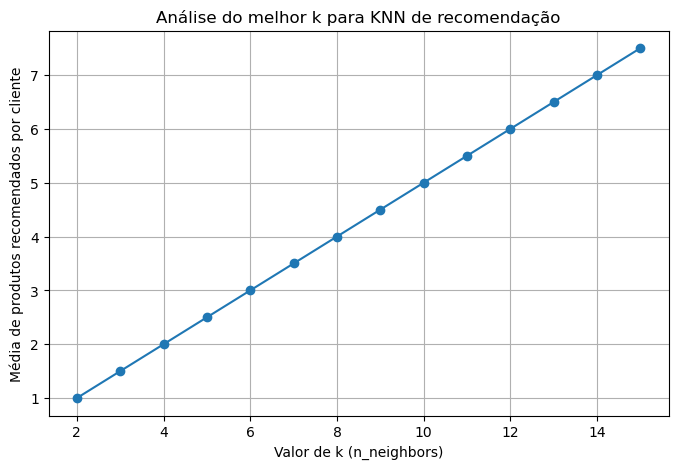

In [20]:
# 5. Plotar gráfico
plt.figure(figsize=(8,5))
plt.plot(ks, medias, marker='o')
plt.xlabel("Valor de k (n_neighbors)")
plt.ylabel("Média de produtos recomendados por cliente")
plt.title("Análise do melhor k para KNN de recomendação")
plt.grid(True)
plt.show()
print()

In [21]:
# 6. Encontrar o melhor k (maior média, critério simples)
best_k = ks[np.argmax(medias)]
print(f"\nMelhor k (pelo critério de mais recomendações médias): {best_k} - média = {max(medias):.2f}")


Melhor k (pelo critério de mais recomendações médias): 15 - média = 7.50


**Parte 8.2 - Modelo machine learning**

In [22]:
# Modelo KNN
knn = NearestNeighbors(n_neighbors=best_k, metric='cosine')
knn.fit(X)

,n_neighbors,15
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


**Parte 8.3 - Recomendação**

In [23]:
def recomendar_knn_por_indice(idx_cliente, top_n=3):
    """
    Recebe índice do cliente na base e retorna recomendações de produtos.
    """
    dist, idxs = knn.kneighbors([X.iloc[idx_cliente]], n_neighbors=k)
    vizinhos = idxs.flatten()[1:]  # ignora o próprio cliente
    recomendacoes = []
    for prod in produtos:
        if df.iloc[idx_cliente][prod] == 0:
            score = df.iloc[vizinhos][prod].mean()
            recomendacoes.append((prod, score))
    recomendacoes = sorted(recomendacoes, key=lambda x: x[1], reverse=True)
    return recomendacoes[:top_n]

In [24]:
# Exemplo para o primeiro cliente do DataFrame
idx_cliente = 2  # ou qualquer índice da base
print(f"\nRecomendações para cliente na linha {idx_cliente}:")
for prod, score in recomendar_knn_por_indice(idx_cliente, top_n=5):
    print(f"- {prod} (score: {score:.2f})")

# Ou, se quiser por id_cliente:
def recomendar_knn_por_id(id_cliente, top_n=3):
    idx = df.index[df['id_cliente'] == id_cliente].tolist()
    if not idx:
        print("id_cliente não encontrado.")
        return []
    return recomendar_knn_por_indice(idx[0], top_n=top_n)


Recomendações para cliente na linha 2:
- Crédito Pessoal Flex (score: 0.64)
- Conta Corrente Plus (score: 0.57)
- Cartão Platinum (score: 0.43)


C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [25]:
# Recomendações para os 10 primeiros clientes da base
for idx_cliente in range(25):
    print(f"\n===== Recomendações para cliente na linha {idx_cliente}: =====")
    recs = recomendar_knn_por_indice(idx_cliente, top_n=5)  # pode ajustar o top_n!
    if recs:
        for prod, score in recs:
            print(f"- {prod} (score: {score:.2f})")
    else:
        print("Nenhuma recomendação.")


===== Recomendações para cliente na linha 0: =====
- Crédito Pessoal Flex (score: 0.43)
- Investimento Renda Fixa (score: 0.21)

===== Recomendações para cliente na linha 1: =====
- Investimento Renda Fixa (score: 0.64)
- Cartão Platinum (score: 0.43)
- Seguro Residencial (score: 0.29)
- Crédito Pessoal Flex (score: 0.29)

===== Recomendações para cliente na linha 2: =====
- Crédito Pessoal Flex (score: 0.64)
- Conta Corrente Plus (score: 0.57)
- Cartão Platinum (score: 0.43)

===== Recomendações para cliente na linha 3: =====
- Conta Corrente Plus (score: 0.64)
- Cartão Platinum (score: 0.43)
- Seguro Residencial (score: 0.29)

===== Recomendações para cliente na linha 4: =====
- Investimento Renda Fixa (score: 0.86)
- Seguro Residencial (score: 0.50)

===== Recomendações para cliente na linha 5: =====
- Conta Corrente Plus (score: 0.86)
- Investimento Renda Fixa (score: 0.71)
- Cartão Platinum (score: 0.50)
- Crédito Pessoal Flex (score: 0.43)

===== Recomendações para cliente na li

C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNe

In [26]:
# Para os 10 primeiros id_cliente
for i in range(25):
    id_cli = df['id_cliente'].iloc[i]
    print(f"\n===== Recomendações para id_cliente {id_cli}: =====")
    recs = recomendar_knn_por_id(id_cli, top_n=5)
    if recs:
        for prod, score in recs:
            print(f"- {prod} (score: {score:.2f})")
    else:
        print("Nenhuma recomendação.")



===== Recomendações para id_cliente 1: =====
- Crédito Pessoal Flex (score: 0.43)
- Investimento Renda Fixa (score: 0.21)

===== Recomendações para id_cliente 2: =====
- Investimento Renda Fixa (score: 0.64)
- Cartão Platinum (score: 0.43)
- Seguro Residencial (score: 0.29)
- Crédito Pessoal Flex (score: 0.29)

===== Recomendações para id_cliente 3: =====
- Crédito Pessoal Flex (score: 0.64)
- Conta Corrente Plus (score: 0.57)
- Cartão Platinum (score: 0.43)

===== Recomendações para id_cliente 4: =====
- Conta Corrente Plus (score: 0.64)
- Cartão Platinum (score: 0.43)
- Seguro Residencial (score: 0.29)

===== Recomendações para id_cliente 5: =====
- Investimento Renda Fixa (score: 0.86)
- Seguro Residencial (score: 0.50)

===== Recomendações para id_cliente 6: =====
- Conta Corrente Plus (score: 0.86)
- Investimento Renda Fixa (score: 0.71)
- Cartão Platinum (score: 0.50)
- Crédito Pessoal Flex (score: 0.43)

===== Recomendações para id_cliente 7: =====
- Cartão Platinum (score: 0.5

C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNe

- Seguro Residencial (score: 0.36)
- Crédito Pessoal Flex (score: 0.36)

===== Recomendações para id_cliente 11: =====
- Investimento Renda Fixa (score: 0.71)
- Cartão Platinum (score: 0.57)

===== Recomendações para id_cliente 12: =====
- Cartão Platinum (score: 0.43)
- Seguro Residencial (score: 0.36)
- Crédito Pessoal Flex (score: 0.36)
- Investimento Renda Fixa (score: 0.14)

===== Recomendações para id_cliente 13: =====
- Investimento Renda Fixa (score: 0.57)
- Seguro Residencial (score: 0.43)
- Crédito Pessoal Flex (score: 0.21)

===== Recomendações para id_cliente 14: =====
- Investimento Renda Fixa (score: 0.57)
- Cartão Platinum (score: 0.50)

===== Recomendações para id_cliente 15: =====
Nenhuma recomendação.

===== Recomendações para id_cliente 16: =====
- Conta Corrente Plus (score: 0.86)
- Cartão Platinum (score: 0.29)

===== Recomendações para id_cliente 17: =====
- Seguro Residencial (score: 0.43)

===== Recomendações para id_cliente 18: =====
- Conta Corrente Plus (scor

C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNe

C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNe

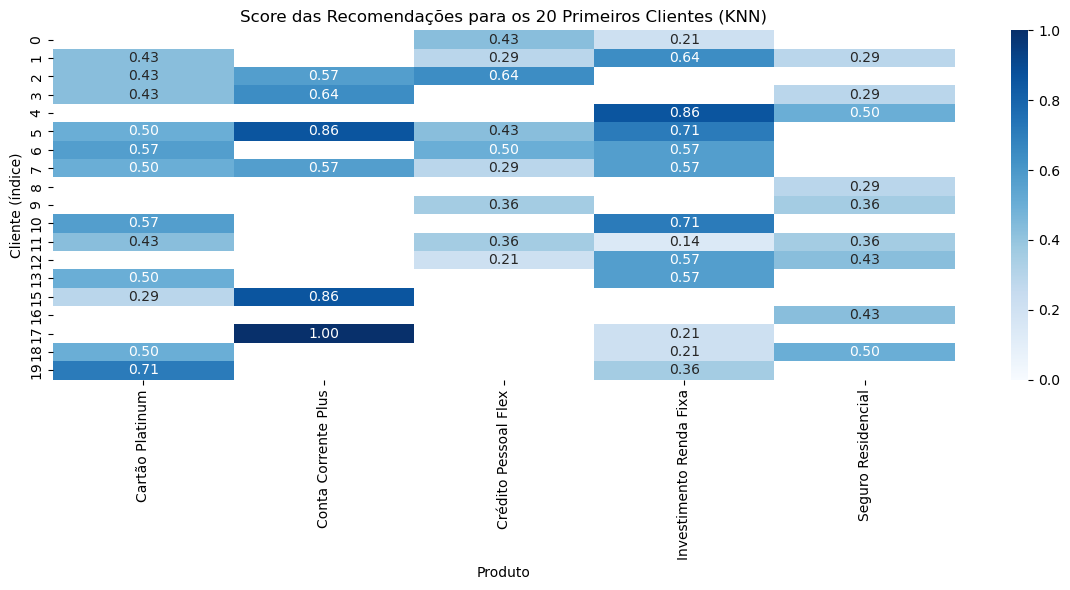

In [27]:
clientes = []
produtos_rec = []
scores = []

for idx_cliente in range(20):
    recs = recomendar_knn_por_indice(idx_cliente, top_n=5)
    for prod, score in recs:
        clientes.append(idx_cliente)
        produtos_rec.append(prod)
        scores.append(score)

df_recs = pd.DataFrame({
    "cliente": clientes,
    "produto": produtos_rec,
    "score": scores
})

pivot = df_recs.pivot(index='cliente', columns='produto', values='score')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="Blues", vmin=0, vmax=1, fmt=".2f")
plt.title("Score das Recomendações para os 20 Primeiros Clientes (KNN)")
plt.xlabel("Produto")
plt.ylabel("Cliente (índice)")
plt.tight_layout()
plt.show()

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_23408\1454165632.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='produto', y='score', data=df_recs, estimator='mean', ci=None)


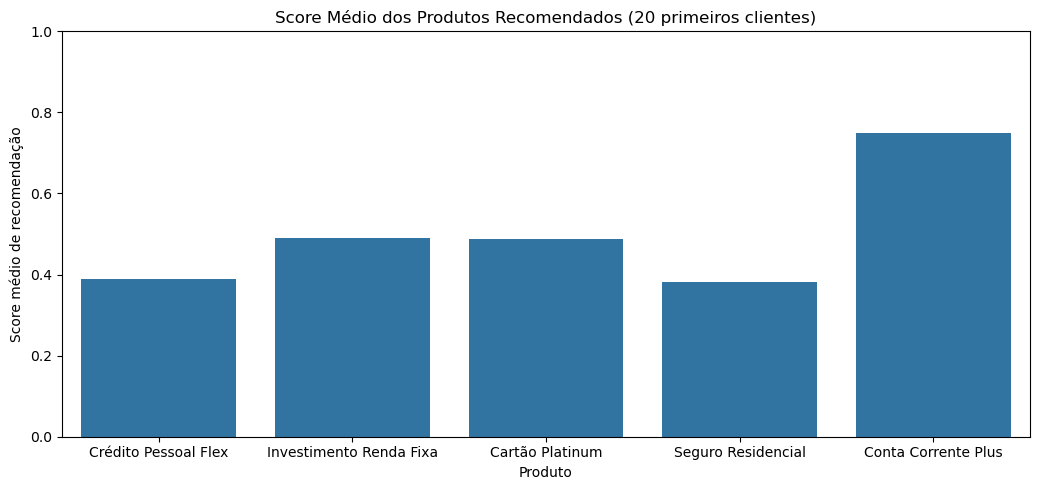

In [28]:
plt.figure(figsize=(10.5, 5))
sns.barplot(x='produto', y='score', data=df_recs, estimator='mean', ci=None)
plt.title("Score Médio dos Produtos Recomendados (20 primeiros clientes)")
plt.ylabel("Score médio de recomendação")
plt.xlabel("Produto")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNe

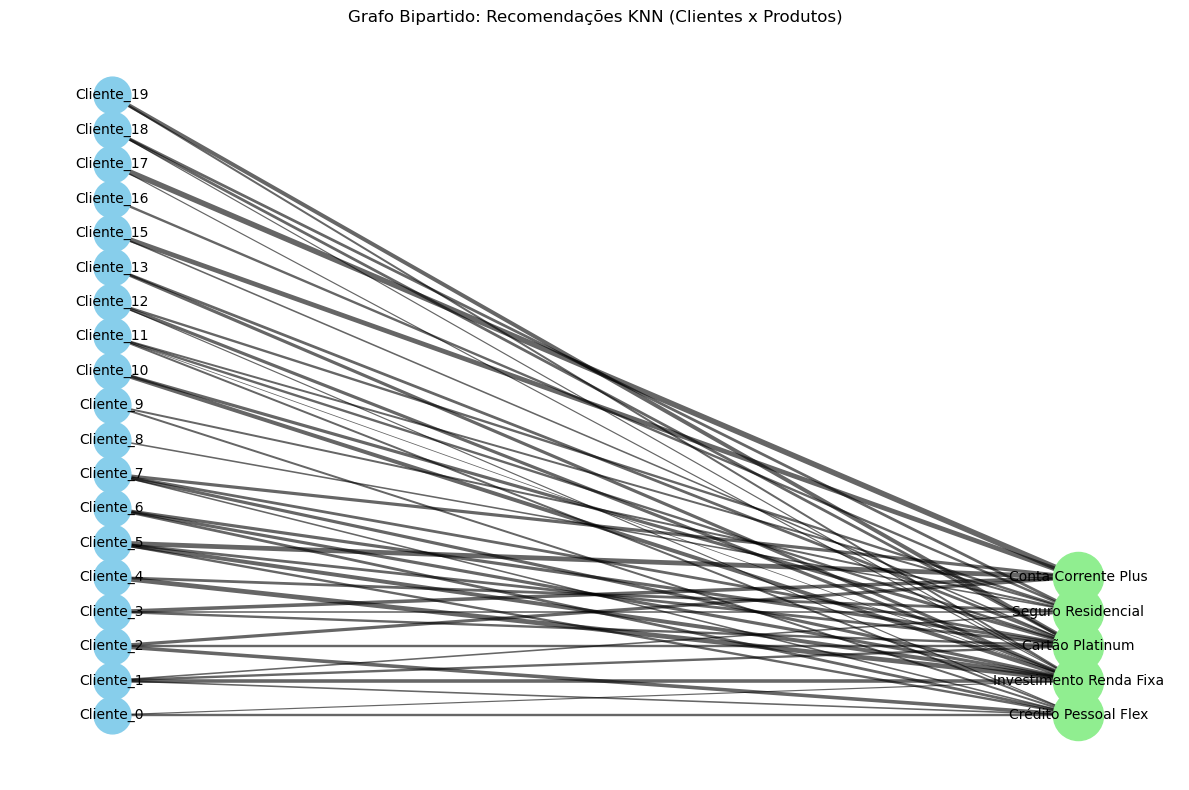

In [29]:
import networkx as nx

clientes = []
produtos_rec = []
scores = []

for idx_cliente in range(20):
    recs = recomendar_knn_por_indice(idx_cliente, top_n=5)
    for prod, score in recs:
        clientes.append(f"Cliente_{idx_cliente}")
        produtos_rec.append(prod)
        scores.append(score)

df_edges = pd.DataFrame({
    "cliente": clientes,
    "produto": produtos_rec,
    "score": scores
})

##
#
G = nx.Graph()

# Adicione nós de clientes (um grupo) e produtos (outro grupo)
clientes_nodes = df_edges['cliente'].unique()
produtos_nodes = df_edges['produto'].unique()
G.add_nodes_from(clientes_nodes, bipartite=0)
G.add_nodes_from(produtos_nodes, bipartite=1)

# Adicione as arestas (com score)
for _, row in df_edges.iterrows():
    G.add_edge(row['cliente'], row['produto'], weight=row['score'])

# Layout: clientes à esquerda, produtos à direita (bipartido)
from networkx.drawing.layout import bipartite_layout
pos = {}
pos.update((n, (0, i)) for i, n in enumerate(clientes_nodes))
pos.update((n, (1, i)) for i, n in enumerate(produtos_nodes))

# Desenhe os nós
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, nodelist=clientes_nodes, node_color='skyblue', node_size=700, label='Clientes')
nx.draw_networkx_nodes(G, pos, nodelist=produtos_nodes, node_color='lightgreen', node_size=1300, label='Produtos')

# Desenhe as arestas (score determina a largura)
edges = G.edges(data=True)
weights = [d['weight'] * 4 for (u, v, d) in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.6)

# Rótulos dos nós
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Grafo Bipartido: Recomendações KNN (Clientes x Produtos)")
plt.axis('off')
plt.tight_layout()
plt.show()


**Parte 8.4 - Recomendação por similaridade cosseno**

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

# 4. Calcule a matriz de similaridade do cosseno
sim_matrix = cosine_similarity(X)

In [31]:
# Função de recomendação baseada no cosseno (para um cliente)
def recomendar_por_cosseno(idx_cliente, top_n_vizinhos=5, top_n_produtos=3):
    # Similaridade desse cliente com todos
    sims = sim_matrix[idx_cliente]
    # Índices dos vizinhos mais similares (excluindo ele mesmo)
    vizinhos_idx = sims.argsort()[::-1][1:top_n_vizinhos+1]
    
    recomendacoes = []
    for prod in produtos:
        # Só recomenda se cliente ainda não tem
        if df.iloc[idx_cliente][prod] == 0:
            # Score: % dos vizinhos que têm o produto
            score = df.iloc[vizinhos_idx][prod].mean()
            recomendacoes.append((prod, score))
    
    recomendacoes = sorted(recomendacoes, key=lambda x: x[1], reverse=True)
    return recomendacoes[:top_n_produtos]

In [32]:
# recomendar para os 10 primeiros clientes
for idx_cliente in range(10):
    print(f"\n===== Recomendação por similaridade do cosseno: Cliente linha {idx_cliente} =====")
    recs = recomendar_por_cosseno(idx_cliente, top_n_vizinhos=5, top_n_produtos=3)
    for prod, score in recs:
        print(f"- {prod} (score: {score:.2f})")


===== Recomendação por similaridade do cosseno: Cliente linha 0 =====
- Crédito Pessoal Flex (score: 0.40)
- Investimento Renda Fixa (score: 0.20)

===== Recomendação por similaridade do cosseno: Cliente linha 1 =====
- Cartão Platinum (score: 0.60)
- Investimento Renda Fixa (score: 0.60)
- Seguro Residencial (score: 0.40)

===== Recomendação por similaridade do cosseno: Cliente linha 2 =====
- Crédito Pessoal Flex (score: 0.80)
- Conta Corrente Plus (score: 0.60)
- Cartão Platinum (score: 0.20)

===== Recomendação por similaridade do cosseno: Cliente linha 3 =====
- Conta Corrente Plus (score: 0.60)
- Cartão Platinum (score: 0.60)
- Seguro Residencial (score: 0.20)

===== Recomendação por similaridade do cosseno: Cliente linha 4 =====
- Investimento Renda Fixa (score: 0.80)
- Seguro Residencial (score: 0.40)

===== Recomendação por similaridade do cosseno: Cliente linha 5 =====
- Conta Corrente Plus (score: 0.80)
- Cartão Platinum (score: 0.60)
- Investimento Renda Fixa (score: 0.60)

In [33]:
produtos = [
    "Conta Corrente Plus", "Cartão Platinum", "Seguro Residencial",
    "Crédito Pessoal Flex", "Investimento Renda Fixa"
]

prod_df = df[produtos]
sim_matrix = cosine_similarity(prod_df.T)

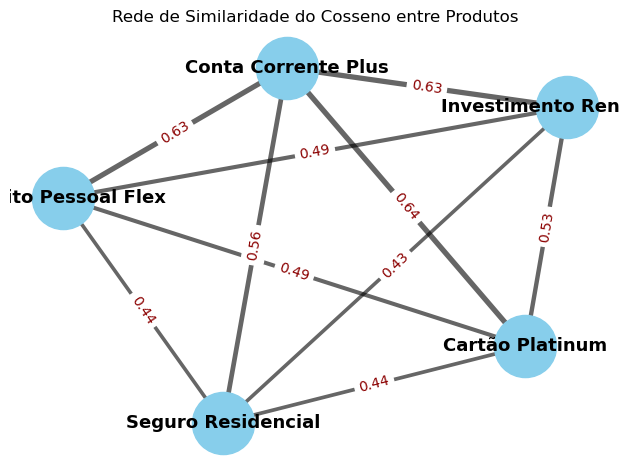

In [34]:
import networkx as nx

# Crie o grafo
G = nx.Graph()

# Adicione nós (produtos)
for prod in produtos:
    G.add_node(prod)

# Adicione arestas para similaridades acima de threshold (ex: 0.2)
threshold = 0.2
for i in range(len(produtos)):
    for j in range(i+1, len(produtos)):
        sim = sim_matrix[i, j]
        if sim > threshold:
            G.add_edge(produtos[i], produtos[j], weight=sim)

# Layout dos nós
pos = nx.spring_layout(G, seed=42, k=0.7)

# Desenhe os nós
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000)

# Desenhe os rótulos
nx.draw_networkx_labels(G, pos, font_size=13, font_weight='bold')

# Pegue as arestas e pesos
edges = G.edges(data=True)
weights = [d['weight']*6 for (u,v,d) in edges]  # escala visual

# Desenhe as arestas (largura proporcional ao peso)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.6)

# Escreva o valor da similaridade em cada aresta
edge_labels = {(u, v): f"{d['weight']:.2f}" for (u, v, d) in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred')

plt.title("Rede de Similaridade do Cosseno entre Produtos")
plt.axis('off')
plt.tight_layout()
plt.show()

# Parte 9 - Cluster k-means

In [35]:
features = [
    "idade", "sexo", "cor", "casado", "qt_filhos", "cidade", "renda",
    "qt_carros", "qt_cart_cred", "casa_propria", "credit_score", "endivid", "trabalha"
]
produtos = [
    "Conta Corrente Plus", "Cartão Platinum", "Seguro Residencial",
    "Crédito Pessoal Flex", "Investimento Renda Fixa"
]

In [36]:
# LabelEncoder para as categóricas
for col in ["sexo", "cor", "cidade"]:
    if df[col].dtype == "object":
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

**Parte 9.1 - Padronização**

In [37]:
# Padronização das features (importante para KMeans)
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

scaler

,copy,True
,with_mean,True
,with_std,True


**Parte 9.2 - Encontrando o valor de cluster**

C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3

Testando n_clusters=1 ➔ inertia=130000.00
Testando n_clusters=2 ➔ inertia=118775.23
Testando n_clusters=3 ➔ inertia=112294.31
Testando n_clusters=4 ➔ inertia=109478.78
Testando n_clusters=5 ➔ inertia=104547.18
Testando n_clusters=6 ➔ inertia=102250.76
Testando n_clusters=7 ➔ inertia=100455.42
Testando n_clusters=8 ➔ inertia=98307.72
Testando n_clusters=9 ➔ inertia=96731.87
Testando n_clusters=10 ➔ inertia=94876.90
Testando n_clusters=11 ➔ inertia=93571.42
Testando n_clusters=12 ➔ inertia=92481.41
Testando n_clusters=13 ➔ inertia=91661.54
Testando n_clusters=14 ➔ inertia=90585.38


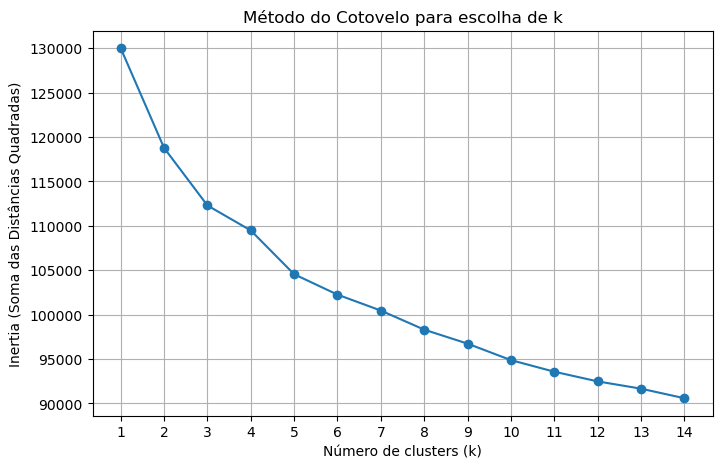

In [38]:
# Encontrando o valor de cluster

inertias = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    print(f"Testando n_clusters={k} ➔ inertia={kmeans.inertia_:.2f}")

plt.figure(figsize=(8,5))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inertia (Soma das Distâncias Quadradas)")
plt.title("Método do Cotovelo para escolha de k")
plt.xticks(list(K_range))
plt.grid(True)
plt.show()

In [39]:
#
from kneed import KneeLocator

#
kl = KneeLocator(list(K_range), inertias, curve="convex", direction="decreasing")
k_otimo = kl.elbow
print(f"\n>>> Melhor valor de n_clusters pelo cotovelo: {k_otimo}")


>>> Melhor valor de n_clusters pelo cotovelo: 5


**Parte 9.3 - Modelo K-Means**

In [40]:
# Modelo kmenas
n_clusters = k_otimo
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Visualizando modelo
kmeans

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [41]:
# Clusters
df['cluster'] = clusters

**Parte 9.4 - Recomendações por cluster**

In [42]:
# Descubra os produtos mais comuns por cluster (ex: Top 2)
top_n = 2
recomendacoes_por_cluster = {}

for cl in range(n_clusters):
    grupo = df[df['cluster'] == cl]
    populares = grupo[produtos].mean().sort_values(ascending=False)
    recomendacoes_por_cluster[cl] = list(populares.head(top_n).index)

print("Produtos recomendados por cluster:")
for cl, recs in recomendacoes_por_cluster.items():
    print(f"Cluster {cl}: {recs}")

Produtos recomendados por cluster:
Cluster 0: ['Conta Corrente Plus', 'Seguro Residencial']
Cluster 1: ['Conta Corrente Plus', 'Cartão Platinum']
Cluster 2: ['Conta Corrente Plus', 'Investimento Renda Fixa']
Cluster 3: ['Conta Corrente Plus', 'Cartão Platinum']
Cluster 4: ['Conta Corrente Plus', 'Crédito Pessoal Flex']


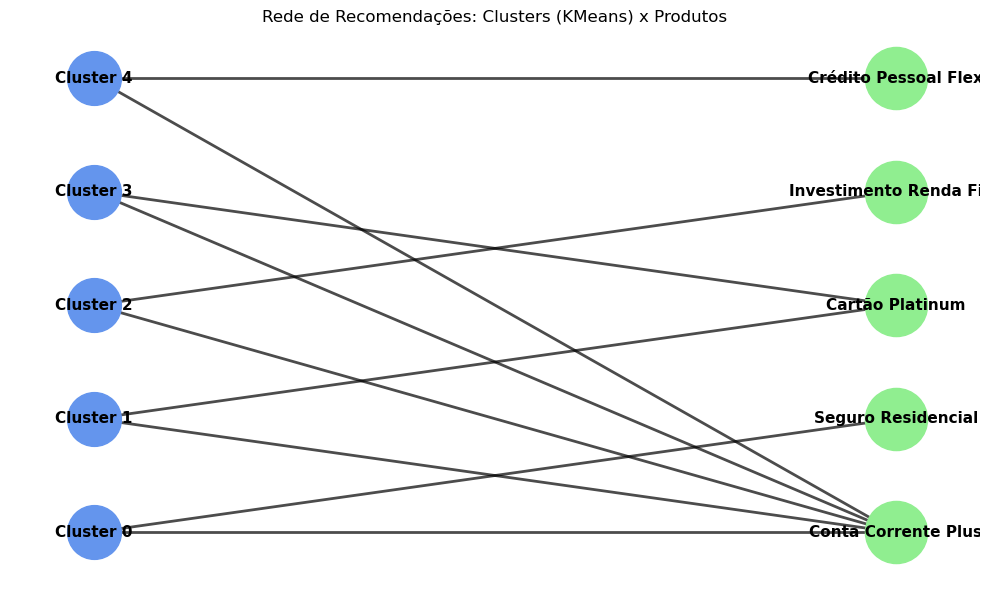

In [43]:
# Supondo recomendacoes_por_cluster como antes
# Exemplo: {0: ['Cartão Platinum', 'Investimento Renda Fixa'], 1: ['Seguro Residencial', 'Conta Corrente Plus'], ...}

edges = []
for cl, recs in recomendacoes_por_cluster.items():
    for prod in recs:
        edges.append(("Cluster " + str(cl), prod))

# Criando o grafo bipartido
G = nx.Graph()
G.add_edges_from(edges)

# Define grupos para visualização (clusters à esquerda, produtos à direita)
clusters = [n for n in G.nodes if n.startswith("Cluster")]
produtos_nodes = [n for n in G.nodes if n not in clusters]

pos = {}
pos.update((n, (0, i)) for i, n in enumerate(clusters))
pos.update((n, (1, i)) for i, n in enumerate(produtos_nodes))

plt.figure(figsize=(10,6))
nx.draw_networkx_nodes(G, pos, nodelist=clusters, node_color='cornflowerblue', node_size=1500, label='Clusters')
nx.draw_networkx_nodes(G, pos, nodelist=produtos_nodes, node_color='lightgreen', node_size=2000, label='Produtos')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

plt.title("Rede de Recomendações: Clusters (KMeans) x Produtos")
plt.axis('off')
plt.tight_layout()
plt.show()

In [44]:
# Salvando modelo
import joblib

# Salve o modelo para arquivo
joblib.dump(knn, r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Recommendations Systems\trabalho_final\models\modelo_knn.joblib")
print("Modelo KNN salvo como modelo_knn.joblib")

Modelo KNN salvo como modelo_knn.joblib
